
Average acceptance rate: 0.359530


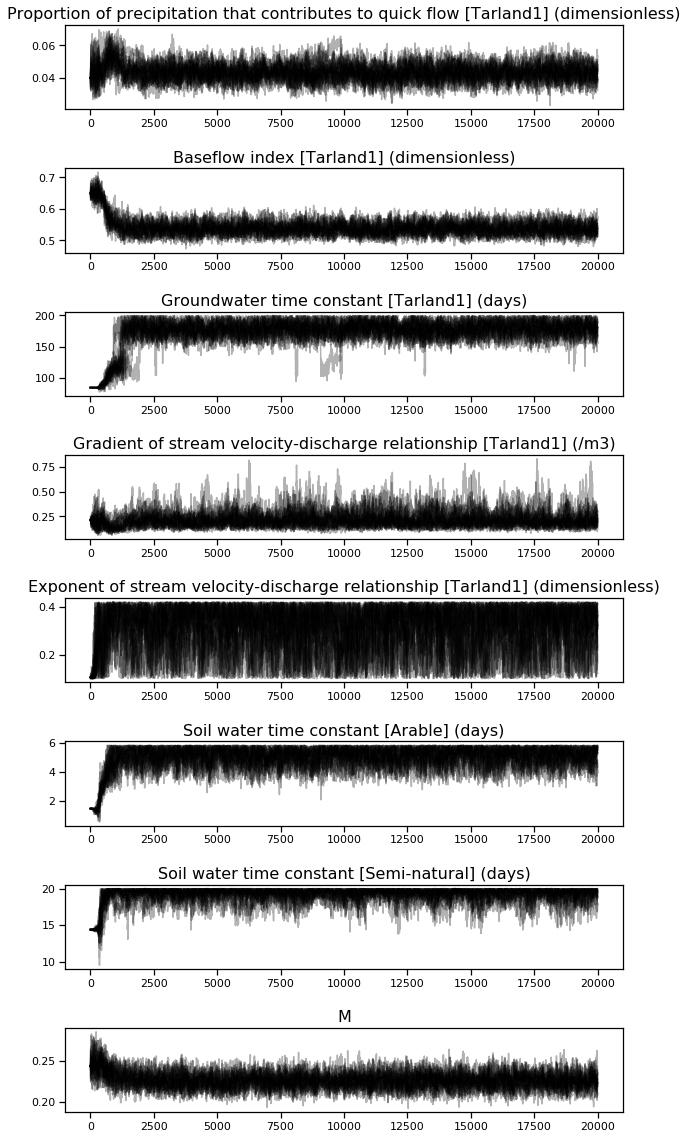

array([[4.17252069e-02, 5.47591585e-01, 1.12928720e+02, ...,
        3.34427169e+00, 1.95153764e+01, 2.57467793e-01],
       [4.17252069e-02, 5.47591585e-01, 1.12928720e+02, ...,
        3.34427169e+00, 1.95153764e+01, 2.57467793e-01],
       [4.17252069e-02, 5.47591585e-01, 1.12928720e+02, ...,
        3.34427169e+00, 1.95153764e+01, 2.57467793e-01],
       ...,
       [4.28770734e-02, 5.34350662e-01, 1.75564685e+02, ...,
        5.81545185e+00, 1.99941879e+01, 2.27716395e-01],
       [4.31233320e-02, 5.34421753e-01, 1.75997868e+02, ...,
        5.79477286e+00, 1.99839069e+01, 2.27513303e-01],
       [4.31233320e-02, 5.34421753e-01, 1.75997868e+02, ...,
        5.79477286e+00, 1.99839069e+01, 2.27513303e-01]])

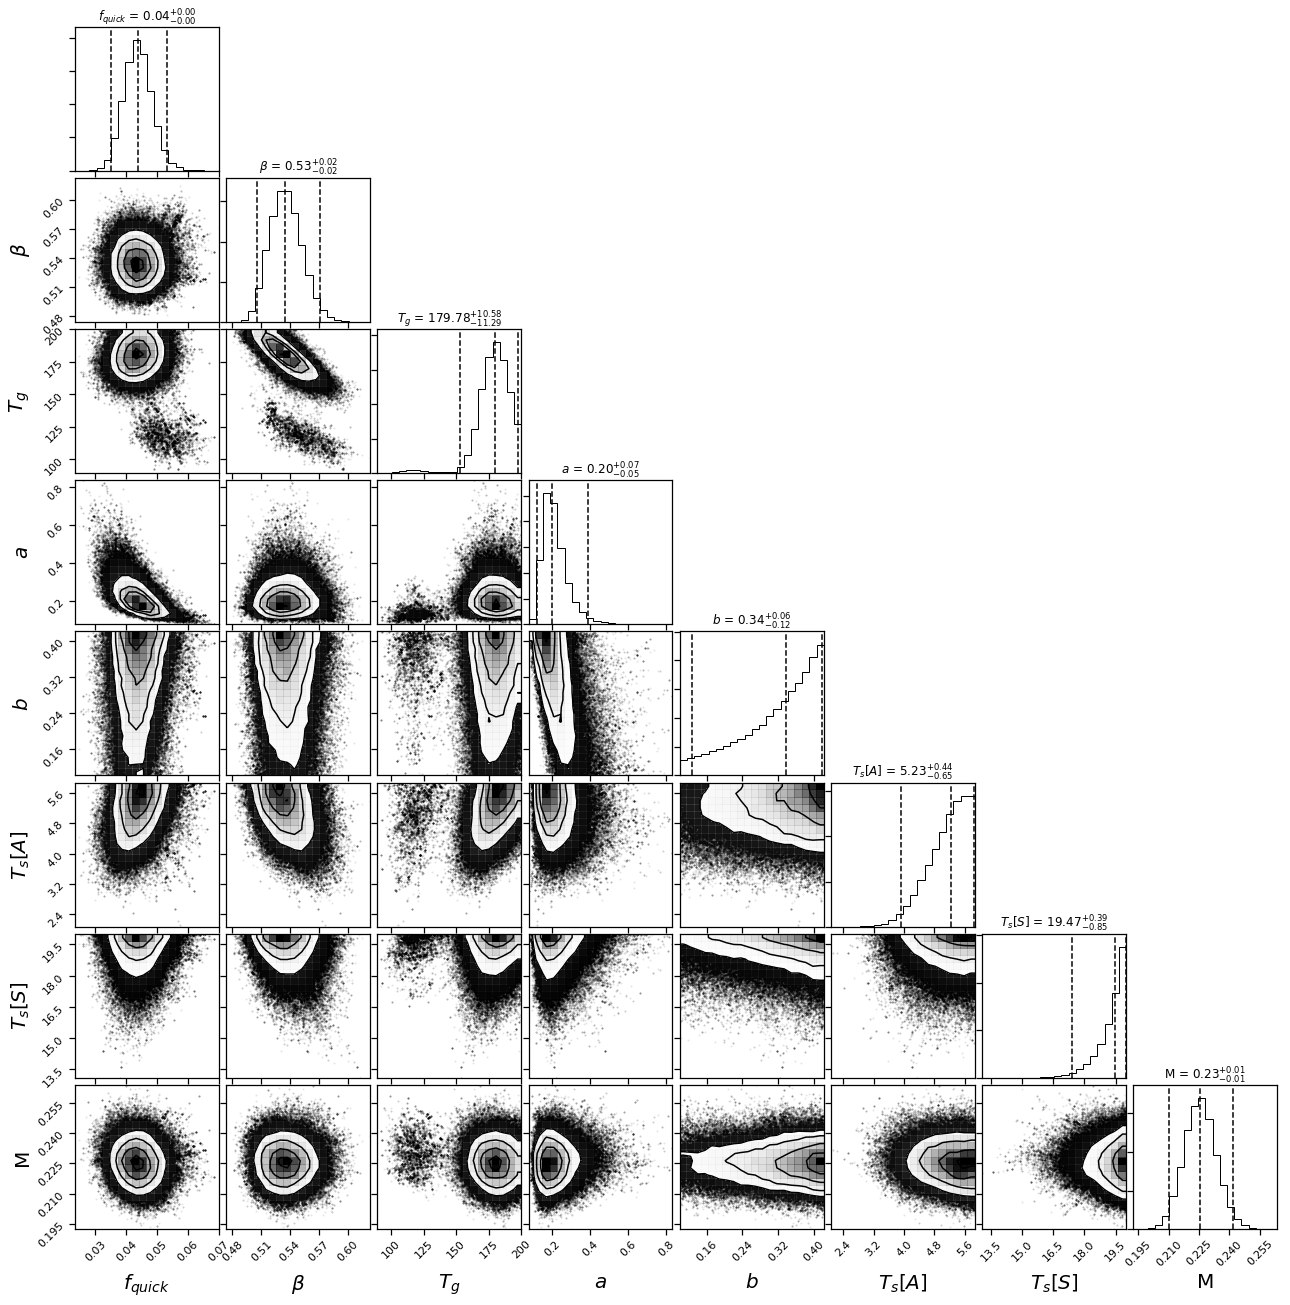

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, emcee, corner, mpld3
import inca
from inca_calibration import *
import numpy as np
from scipy.stats import norm
from IPython import parallel
#c = parallel.Client()
#view = c.load_balanced_view()
sn.set_context('notebook')

def log_likelyhood(params, dataset, calibration, objective, obs):
    # NOTE: If we use a parallellized optimizer we need to make a copy of the dataset to not have several threads overwrite each other.
    # (in that case, only use the copy when setting parameter values, running the model, and extracting results below)
    datasetcopy = dataset.copy()
    
    set_values(datasetcopy, params, calibration)
    
    datasetcopy.run_model()
    
    fn, simname, simindexes, obsname, obsindexes, skiptimesteps = objective
    
    sim = datasetcopy.get_result_series(simname, simindexes)
    sim2 = sim[skiptimesteps:]
    obs2 = obs[skiptimesteps:]
    
    M = params[len(calibration)]
    sigma_e = M*sim2
    
    likes = norm(sim2, sigma_e).logpdf(obs2)
    
    like = np.nansum(likes)
    
    # NOTE: If we made a copy of the dataset we need to delete it so that we don't get a huge memory leak
    datasetcopy.delete()
    
    #print ('single evaluation. result: %f' % like)
    
    return like
    

inca.initialize('simplyp.dll')

dataset = inca.DataSet.setup_from_parameter_and_input_files('optimal_parameters.dat', '../Applications/SimplyP/tarlandinputs.dat')

calibration = [
    ('Proportion of precipitation that contributes to quick flow', ['Tarland1']),
    ('Baseflow index',                                             ['Tarland1']),
    ('Groundwater time constant',                                  ['Tarland1']),
    ('Gradient of stream velocity-discharge relationship',         ['Tarland1']),
    ('Exponent of stream velocity-discharge relationship',         ['Tarland1']),
    ('Soil water time constant',                                   ['Arable']),
    ('Soil water time constant',                                   ['Semi-natural']),
    ]
    
labels_short = [r'$f_{quick}$', r'$\beta$', r'$T_g$', r'$a$', r'$b$', r'$T_s[A]$', r'$T_s[S]$']

#NOTE: This reads the initial guess that was provided by the parameter file.
initial_guess = default_initial_guess(dataset, calibration)
initial_guess.append(0.243586) # This is the initial M.

min = [0.25 * x for x in initial_guess]
max = [4.0 * x for x in initial_guess]

#NOTE: Constrain to the min and max values recommended by the model in case we made our bounds too wide.
constrain_min_max(dataset, calibration, min, max)

skiptimesteps = 50   # Skip these many of the first timesteps in the objective evaluation

objective = (log_likelyhood, 'Daily mean reach flow', ['Tarland1'], 'observed Q mm/d', [], skiptimesteps)

def run_emcee2(dataset, min, max, initial_guess, calibration, objective, n_walk, n_steps, n_burn, truths=None) :
    
    log_likelyhood, simname, simindexes, obsname, obsindexes, skiptimesteps = objective
    
    obs = dataset.get_input_series(obsname, obsindexes, alignwithresults=True)
    
    n_dim = len(initial_guess)
    
    def log_prior(params) :
        if check_min_max(params, min, max) :
            return 0
        return -np.inf

    def log_posterior(params):
        log_pri = log_prior(params)
        
        if(np.isfinite(log_pri)):
            log_like = log_likelyhood(params, dataset, calibration, objective, obs)
            return log_pri + log_like
        return -np.inf

    starting_guesses = [initial_guess + 1e-4*np.random.randn(n_dim) for i in range(n_walk)]

    sampler = emcee.EnsembleSampler(n_walk, n_dim, log_posterior)#, pool=view)
    
    pos, prob, state = sampler.run_mcmc(starting_guesses, n_steps)
    
    print('\nAverage acceptance rate: %f' % np.mean(sampler.acceptance_fraction))
    
    labels_short.append(r'M')
    
    param_labels = ['%s [%s] (%s)' % (cal[0], ', '.join(cal[1]), dataset.get_parameter_unit(cal[0])) 
                    for cal in calibration]
    param_labels.append('M')
    
    fig, axes = plt.subplots(nrows=n_dim, ncols=1, figsize=(10, 20))    
    for idx, title in enumerate(param_labels):        
        axes[idx].plot(sampler.chain[:,:,idx].T, '-', color='k', alpha=0.3)
        axes[idx].set_title(title, fontsize=16) 
    plt.subplots_adjust(hspace=0.7)    
    plt.show()
    
    samples = sampler.chain[:, n_burn:, :].reshape((-1, n_dim))
    
    # Triangle plot
    tri = corner.corner(samples,
                        labels=labels_short,
                        truths=truths,
                        quantiles=[0.025, 0.5, 0.975],
                        show_titles=True, 
                        title_args={'fontsize': 24},
                        label_kwargs={'fontsize': 20})
    
    return samples

run_emcee2(dataset, min, max, initial_guess, calibration, objective, n_walk=20, n_steps=20000, n_burn=1000)

